Project

# Flight Price Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

## Loading Dataset

In [16]:
data = pd.read_excel("Flight_Train.xlsx")
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Exploratory Data Analysis

In [17]:
data.shape

(10683, 11)

In [18]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [20]:
data.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [21]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [22]:
# Dropping null values
data.dropna(inplace=True)
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [23]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

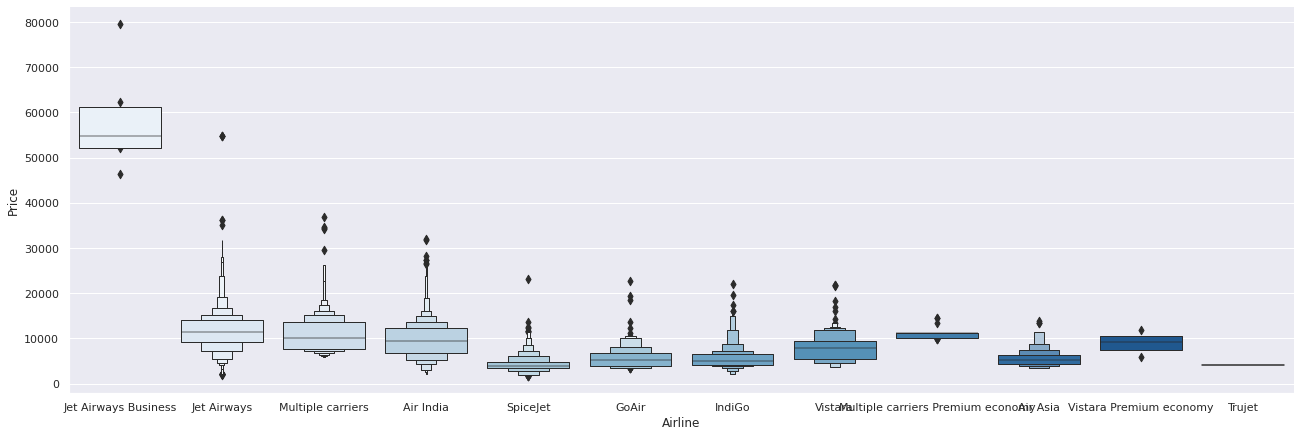

In [24]:
import seaborn as sns
sns.set()
sns.catplot(y = "Price", x = "Airline", data = data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3,palette="Blues")
plt.show()

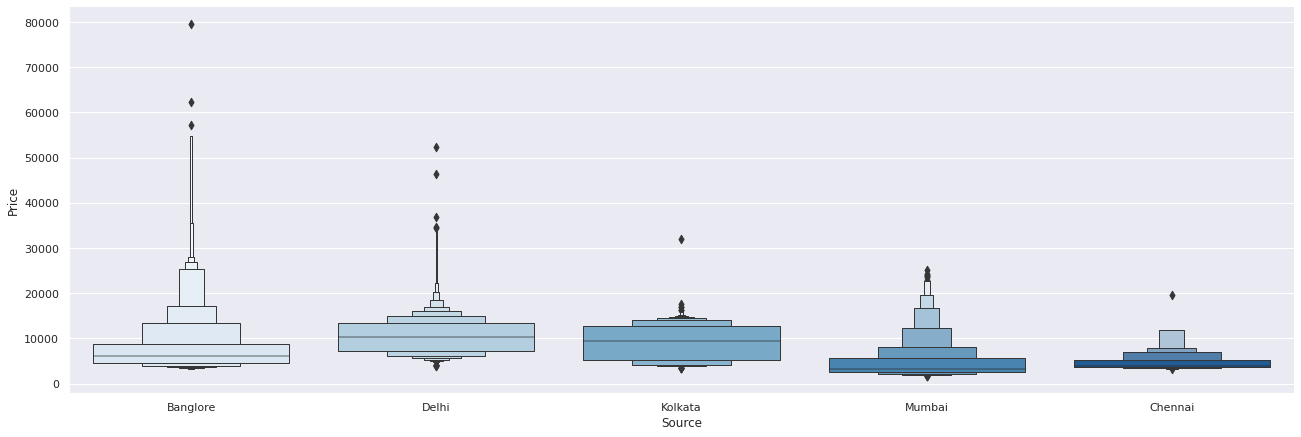

In [25]:
import seaborn as sns
sns.set()
sns.catplot(y = "Price", x = "Source", data = data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3,palette="Blues")
plt.show()

## Feature Engineering

In [26]:
#Splitting the Date_of_Journey column into day and month columns
data["Journey_day"] =pd.to_datetime(data["Date_of_Journey"],format="%d/%m/%Y").dt.day
data["Journey_month"] =pd.to_datetime(data["Date_of_Journey"],format="%d/%m/%Y").dt.month
data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [27]:
#Splitting the Dep_time column into hour and min columns
data["Dep_hour"] = pd.to_datetime(data["Dep_Time"]).dt.hour
data["Dep_min"] = pd.to_datetime(data["Dep_Time"]).dt.minute
data.drop(["Dep_Time"], axis = 1, inplace = True)

In [28]:
#Splitting the Arrival_time column into hour and min columns
data["Arrival_hour"] = pd.to_datetime(data["Arrival_Time"]).dt.hour
data["Arrival_min"] = pd.to_datetime(data["Arrival_Time"]).dt.minute
data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [29]:
#Splitting the Duration column into hour and min columns
duration = list(data["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i] 
hours = []
mins = []
for i in range(len(duration)):
    hours.append(int(duration[i].split(sep = "h")[0]))
    mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))
data["Duration_hours"] = hours
data["Duration_mins"] = mins
data.drop(["Duration"], axis = 1, inplace = True)

In [30]:
# getting dummies for categorical variables
Air = pd.get_dummies(data[['Airline']], drop_first= True)
Source = pd.get_dummies(data[['Source']], drop_first= True)
Dest = pd.get_dummies(data[['Destination']], drop_first= True)

In [31]:
data.Additional_Info.unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

#### "No Info" has been repeated so we have to replace it

In [32]:
data['Additional_Info']=data['Additional_Info'].str.replace("No info",'No Info')
data['Additional_Info']=pd.get_dummies(data[['Additional_Info']], drop_first= True)

In [33]:
#combining the dummies with the original data
data =pd.concat([data,Air,Source,Dest], axis=1)

In [34]:
from sklearn.preprocessing import LabelEncoder
print(data.Total_Stops.unique())
data["Total_Stops"] = LabelEncoder().fit_transform(data["Total_Stops"])

['non-stop' '2 stops' '1 stop' '3 stops' '4 stops']


In [35]:
#dropping unwanted columns
data.drop(["Route","Airline","Source", "Destination"], axis = 1, inplace = True)

In [36]:
data.head()

,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,4,0,3897,24,3,22,20,1,10,2,...,0,0,0,0,0,0,0,0,0,1
1,1,0,7662,1,5,5,50,13,15,7,...,0,0,0,1,0,0,0,0,0,0
2,1,0,13882,9,6,9,25,4,25,19,...,0,0,1,0,0,1,0,0,0,0
3,0,0,6218,12,5,18,5,23,30,5,...,0,0,0,1,0,0,0,0,0,0
4,0,0,13302,1,3,16,50,21,35,4,...,0,0,0,0,0,0,0,0,0,1


In [37]:
data.shape

(10682, 31)

## Test Set

In [61]:
test_data = pd.read_excel("Flight_Test.xlsx")
test_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included
3,Multiple carriers,21/05/2019,Delhi,Cochin,DEL → BOM → COK,08:00,21:00,13h,1 stop,No info
4,Air Asia,24/06/2019,Banglore,Delhi,BLR → DEL,23:55,02:45 25 Jun,2h 50m,non-stop,No info


### Repeating the modifications that we did for training dataset

In [62]:
#Splitting the Date_of_Journey column into day and month columns
test_data["Journey_day"] =pd.to_datetime(test_data["Date_of_Journey"],format="%d/%m/%Y").dt.day
test_data["Journey_month"] =pd.to_datetime(test_data["Date_of_Journey"],format="%d/%m/%Y").dt.month
test_data.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [63]:
#Splitting the Dep_time column into hour and min columns
test_data["Dep_hour"] = pd.to_datetime(test_data["Dep_Time"]).dt.hour
test_data["Dep_min"] = pd.to_datetime(test_data["Dep_Time"]).dt.minute
test_data.drop(["Dep_Time"], axis = 1, inplace = True)

In [64]:
#Splitting the Arrival_time column into hour and min columns
test_data["Arrival_hour"] = pd.to_datetime(test_data["Arrival_Time"]).dt.hour
test_data["Arrival_min"] = pd.to_datetime(test_data["Arrival_Time"]).dt.minute
test_data.drop(["Arrival_Time"], axis = 1, inplace = True)

In [65]:
#Splitting the Duration column into hour and min columns
duration = list(test_data["Duration"])
for i in range(len(duration)):
    if len(duration[i].split()) != 2:
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"
        else:
            duration[i] = "0h " + duration[i] 
hours = []
mins = []
for i in range(len(duration)):
    hours.append(int(duration[i].split(sep = "h")[0]))
    mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))
test_data["Duration_hours"] = hours
test_data["Duration_mins"] = mins
test_data.drop(["Duration"], axis = 1, inplace = True)

In [66]:
# getting dummies for categorical variables
Air = pd.get_dummies(test_data[['Airline']], drop_first= True)
Source = pd.get_dummies(test_data[['Source']], drop_first= True)
Dest = pd.get_dummies(test_data[['Destination']], drop_first= True)

In [67]:
#combining the dummies with the original data
test_data =pd.concat([test_data,Air,Source,Dest], axis=1)

In [68]:
from sklearn.preprocessing import LabelEncoder
print(test_data.Total_Stops.unique())
test_data["Total_Stops"] = LabelEncoder().fit_transform(test_data["Total_Stops"])

['1 stop' 'non-stop' '2 stops' '3 stops' '4 stops']


In [71]:
#dropping unwanted columns
test_data.drop(["Route","Airline","Source", "Destination","Additional_Info"], axis = 1, inplace = True)

In [72]:
test_data.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins,Airline_Air India,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,6,6,17,30,4,25,10,55,0,...,0,0,1,0,0,1,0,0,0,0
1,0,12,5,6,20,10,20,4,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,21,5,19,15,19,0,23,45,0,...,0,0,1,0,0,1,0,0,0,0
3,0,21,5,8,0,21,0,13,0,0,...,0,0,1,0,0,1,0,0,0,0
4,4,24,6,23,55,2,45,2,50,0,...,0,0,0,0,0,0,1,0,0,0


## Model Building

In [134]:
X= data.drop("Price",axis=1)
y = data.Price

In [135]:
#Splitting dataset into training and test set
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

### The Lazy Regressor implements a bunch of machine leanrning model and gives the scores for each model for us to select which one is the best

In [140]:
#pip install lazypredict
from lazypredict.Supervised import LazyRegressor
lr = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = lr.fit(X_train, X_test, y_train, y_test)
models.head(10)

100%|██████████| 42/42 [00:30<00:00,  1.37it/s]


,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
XGBRegressor,0.85,0.85,1797.46,0.27
LGBMRegressor,0.82,0.83,1931.48,0.09
HistGradientBoostingRegressor,0.82,0.83,1936.38,0.51
ExtraTreesRegressor,0.80,0.80,2070.57,1.64
RandomForestRegressor,0.79,0.80,2090.20,1.98
BaggingRegressor,0.79,0.79,2129.67,0.25
GradientBoostingRegressor,0.79,0.79,2130.69,0.66
KNeighborsRegressor,0.78,0.78,2156.78,0.74
ExtraTreeRegressor,0.73,0.73,2391.58,0.04


#### From the results given by the lazyregressor we can concluse that the XGBRegressor has the highest accuracy of 85%.